# imports

In [1]:
# load and autoreload
from IPython import get_ipython


# this automatically updates changes in other file's funcionts. 
# it is very handy for data exploration
try:
    _magic = get_ipython().run_line_magic
    _magic('load_ext', 'autoreload')
    _magic('autoreload', '2')
except:
    pass


# import most used packages
import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

In [2]:
import bnn_tools

In [3]:
# import customs functions

import bnn_tools.funs as fu
import bnn_tools.bnn_array
import bnn_tools.coag_sink as cs
import bnn_tools.basic_funs as bfu

## mean free path

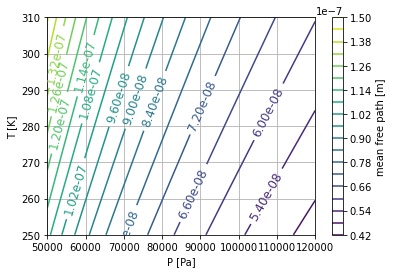

In [4]:
def plt_mean_free_path():
    T_ = xr.DataArray(np.linspace(250,310,100),dims='T',attrs = {'units':'K'})
    P_ = xr.DataArray(np.linspace(50_000,120_000,100),dims='P',attrs={'units':'Pa'})

    Tb,Pb=xr.broadcast(
        T_.assign_coords({'T':T_}),
        P_.assign_coords({'P':P_})
    )
    mfp = cs.calc_MFP(T=Tb,P=Pb)
    mfp.name='mean free path'

    mfp.bnn.u('m')
    #     global res
    #     global ax 
    res = mfp.plot.contour(levels=20,add_colorbar=True)
    ax = plt.gca()
    ax.clabel(res,  # label every second level
          inline=1, fmt='%1.2e', fontsize=12)
    ax.grid(which='both')
plt_mean_free_path()

## viscocity 

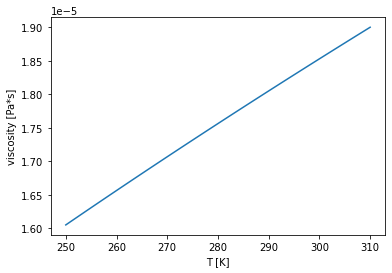

In [5]:
def _plot_vis():
    T_ = xr.DataArray(np.linspace(250,310,100),dims='T',attrs = {'units':'K'})
    T_ = T_.assign_coords({'T':T_})

    _vis = cs.calc_viscosity(T_)
    _vis.name = 'viscosity'
    _vis.bnn.u('Pa*s')


    _vis.plot()
_plot_vis()

## calc_coag_coef_fuchs

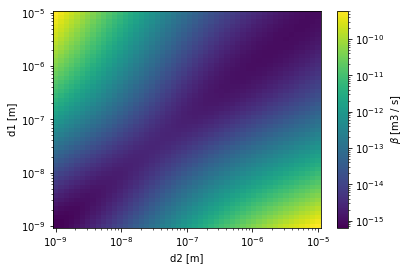

In [6]:
def _plt_coag_coef():
    d1_ = xr.DataArray(np.geomspace(1e-9, 1e-5), dims='d1', attrs={'units': 'm'})
    d2_ = xr.DataArray(np.geomspace(1e-9, 1e-5), dims='d2', attrs={'units': 'm'})
    d1, d2 = xr.broadcast(
        d1_.assign_coords({'d1': d1_}),
        d2_.assign_coords({'d2': d2_})
    )
    alpha = 1
    dens1 = dens2 = 1_000
    T = 300
    P = 101_000
    ccf = cs.calc_coag_coef_fuchs(d1, dens1, d2, dens2, T, P, alpha)
    ccf.name = r'$\beta$'
    ccf.bnn.u('m3 / s')
    ccf.plot(norm=mpl.colors.LogNorm(), yscale='log', xscale='log')
    return ccf
    
ccf = _plt_coag_coef()

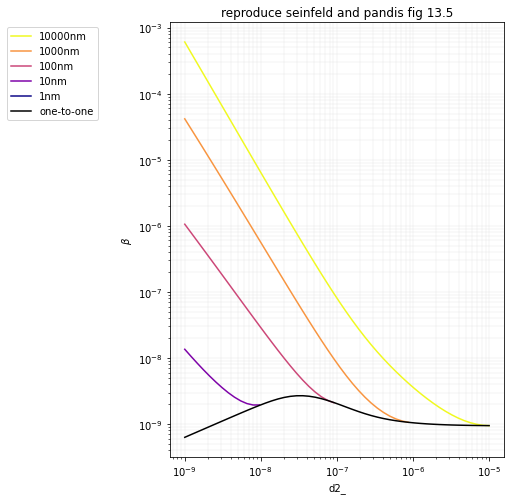

In [7]:
def _plt_pandis(ccf):
    cm = ccf * 1e6
    d2_ = xr.DataArray(np.geomspace(1e-9, 1e-5), dims='d2_', coords={'d2_': np.geomspace(1e-9, 1e-5)})
    d1_ = xr.DataArray(np.geomspace(1e-9, 1e-5), dims='d2_', coords={'d2_': np.geomspace(1e-9, 1e-5)})
    cm_ = cm.interp({'d2': d2_, 'd1': d1_}).reset_coords(drop=True)
    cmap = plt.get_cmap('plasma')
    
    for i in (np.array([1, 10, 100, 1_000, 10_000]) / 1e9)[::-1]:
        cm.interp({'d1': i}).where(cm['d2'] <= i).plot(
            yscale='log', xscale='log',
            label=f'{i * 1e9:1.0f}nm',
            color=cmap((np.log10(i) - np.log10(1e-9)) / np.log10(10_000),
                       )
        )
        
    cm_.plot(c='k', label='one-to-one', zorder = 100)
    ax = plt.gca()
    ax.legend(loc=1, bbox_to_anchor=(-.2, 1))
    ax.grid(which='both', lw=.2, c='.8')
    ax.set_title('reproduce seinfeld and pandis fig 13.5');
    f = plt.gcf()
    f.set_figheight(8)
    
_plt_pandis(ccf)

- it seems quite good 
    - however for 10 um we are overestimated—doubling

## what comes here ? 

# open sum nais file 

In [8]:
_p = os.path.dirname(
    os.path.dirname(bnn_tools.__path__[0])
)

_p


'/Users/aliaga/Documents/Work_DA/Py-packs/bnn-tools-repo'

In [9]:
p = os.path.join(_p,'example_data/NAISn20220515np.sum')
# dataset (xarray) of the sum data. 
ds = fu.open_sum2ds(p)

In [10]:
pp = os.path.join(_p,'example_data/izanapsm2022_inv_kernel_20220515.dat')

In [11]:
ds_psm = fu.open_psm2ds(pp)

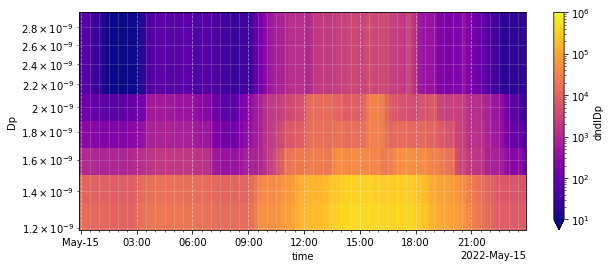

In [12]:
ds_psm.bnn.plot_psd()

# open smsp 

In [13]:
p3 = os.path.join(_p,'example_data/202205101400_SMPS.txt')

In [14]:
ds_s = fu.open_smps2ds(p3).loc[{'time':'2022-05-15'}]

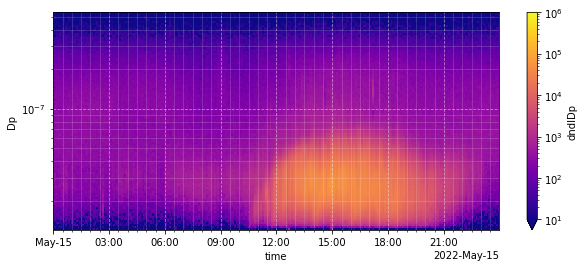

In [15]:
ds_s.bnn.plot_psd()

# combine two along DP

In [16]:
N, _,_ = ds_s.bnn.get_N(d1=10e-9,d2=1)

In [17]:
N

<xarray.DataArray 'N' (time: 286)>
array([  319.00003181,   304.72312837,   303.95304798,   309.62398199,
         314.92418952,   331.63643546,   327.24469163,   335.98377632,
         354.96015589,   346.75078493,   304.37378637,   318.40985095,
         325.65137127,   318.20690998,   316.9349093 ,   312.46165564,
         306.08725225,   311.43579259,   318.99007154,   313.75221386,
         316.76940612,   314.41578079,   318.44351579,   312.26134386,
         318.69703289,   306.89234036,   313.50011684,   316.26297872,
         304.40267959,   302.56342754,   310.42478929,   308.14725928,
         389.02163287,   311.82248299,   302.65293847,   301.4997917 ,
         313.40458873,   309.82184364,   326.3191347 ,   320.19972785,
         297.76614657,   313.4114028 ,   304.82513472,   337.00986283,
         350.11006479,   315.2144125 ,   313.45902014,   345.34923263,
         328.62550276,   305.12049648,   295.82340489,   318.90481252,
         313.49329591,   301.11961202,   311.02241993,   314.29467707,
         312.2124266 ,   306.89918228,   287.65762746,   306.76940701,
         304.6170323 ,   297.82938185,   292.06786941,   311.70664908,
         308.44586595,   306.19133512,   308.70396232,   267.31323769,
         295.35833786,   274.35541411,   273.44162857,   266.19400878,
         297.48203409,   335.78687599,   333.91689066,   342.15511982,
         329.97190647,   352.68782391,   333.20121119,   351.06484852,
...
       11483.33914496, 12807.16778387, 10241.32469294,  9641.23575162,
       10351.1256141 ,  9614.0588654 ,  9579.99327258,  9093.61218872,
       10702.60552559,  9529.6832481 ,  8749.75737742,  9838.8547545 ,
        7440.67849745,  8429.01354635,  6906.74538158,  6780.53415804,
        7216.54219722,  4814.22220804,  4935.56575809,  4213.65233605,
        4377.61112784,  4878.5205615 ,  4189.18797453,  3929.30489075,
        3166.29746727,  3716.55158341,  3508.74238303,  2900.08142669,
        2774.7265159 ,  2835.46928621,  2140.94761373,  1920.61024782,
        2558.87474034,  2383.58632693,  2348.7000304 ,  2256.71204251,
        1630.77147458,  1630.09865004,  1475.09937708,  1339.23009608,
        1271.75223569,  1173.16280034,  1114.61350879,  1389.42369603,
        1363.58078259,  1247.02651192,  1204.16859962,  1098.25495106,
        1044.69071874,   951.67450798,   955.88601302,   913.76751534,
         717.2124055 ,   769.3330275 ,   739.43935686,   710.61821873,
         581.36738741,   590.14094489,   576.38156376,   522.80989682,
         587.70896963,   636.25021349,   482.611912  ,   451.83678508,
         481.81086385,   459.71690806,   398.26683388,   376.87243762,
         356.45726769,   351.17583164,   339.66010751,   327.92913623,
         333.70583065,   334.57253277,   335.23524339,   327.6129931 ,
         332.208492  ,   326.2379045 ])
Coordinates:
  * time     (time) datetime64[ns] 2022-05-15T00:00:50 ... 2022-05-15T23:55:50

In [18]:
ts = 300
dpr = .05
Dp_cut = 3e-9
Dp_cut1 = 20e-9


dsn1 = ds.bnn.resample_ts(ts)[['dndlDp']]

dsn2 = dsn1.bnn.dp_regrid(10,dpr)

dsp1 = ds_psm.bnn.upsample_ts(ts).bnn.set_Dp()

dsp2 = dsp1.bnn.dp_regrid(10,dpr)


dss1 = ds_s.bnn.upsample_ts(ts)[['dndlDp']]


dss2 = dss1.bnn.dp_regrid(10,dpr)

In [19]:
dc = fu.combine_2_spectras(dsp2,dsn2,cut_dim='lDp',cut_point=np.log10(Dp_cut))

dc1 = fu.combine_2_spectras(dc,dss2,cut_dim='lDp',cut_point=np.log10(Dp_cut1))

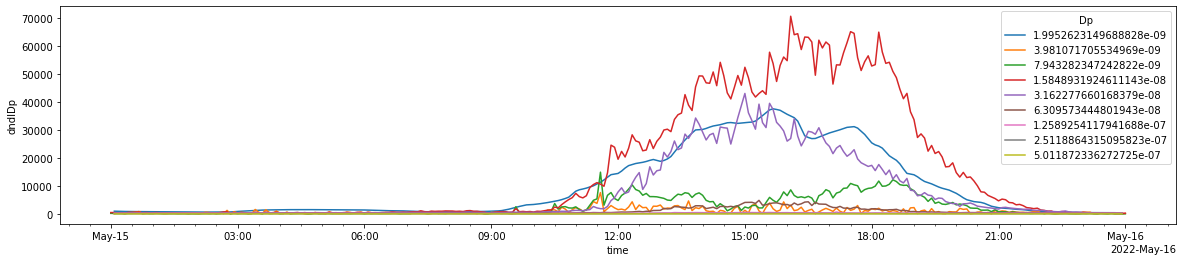

In [141]:
dc1.bnn.set_time().bnn.dp_regrid(10,.3).bnn.set_Dp()['dndlDp'].plot(hue='Dp');
f = plt.gcf()
f.set_figwidth(20)
ax = plt.gca()
bfu.format_ticks(ax)

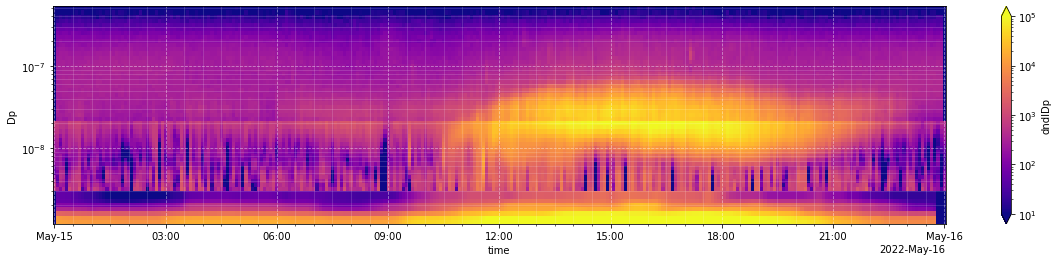

In [20]:
dc1.bnn.plot_psd(vmax=1e5)
f = plt.gcf()
f.set_figwidth(20)

In [ ]:
xr.DataArray.rolling()

In [504]:
dc1_ = dc1
for i in range(5):
    dc1_ = dc1_.rolling({'secs':3},center=True,min_periods=1).mean()

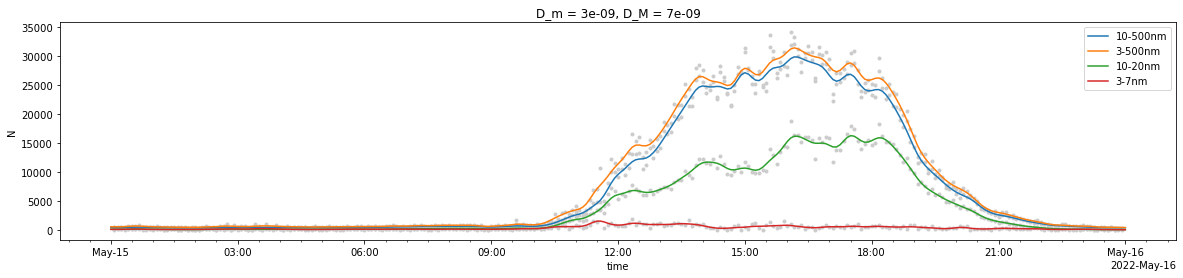

In [510]:
dc1['dndlDp'].bnn.get_exact_N(10e-9,500e-9).bnn.set_time().plot(marker='.',lw=0,c='.8')
dc1['dndlDp'].bnn.get_exact_N(3e-9,500e-9).bnn.set_time(). plot(marker='.',lw=0,c='.8')
dc1['dndlDp'].bnn.get_exact_N(10e-9,20e-9).bnn.set_time(). plot(marker='.',lw=0,c='.8')
dc1['dndlDp'].bnn.get_exact_N(3e-9,7e-9).bnn.set_time().   plot(marker='.',lw=0,c='.8')

dc1_['dndlDp'].bnn.get_exact_N(10e-9,500e-9).bnn.set_time().plot(label='10-500nm')
dc1_['dndlDp'].bnn.get_exact_N(3e-9,500e-9).bnn.set_time().plot(label='3-500nm')
dc1_['dndlDp'].bnn.get_exact_N(10e-9,20e-9).bnn.set_time().plot(label='10-20nm')
dc1_['dndlDp'].bnn.get_exact_N(3e-9,7e-9).bnn.set_time().plot(label='3-7nm')


bfu.format_ticks(plt.gca())
plt.gca().legend()
plt.gcf().set_figwidth(20)
# plt.gca().set_xlim('2022-05-15 09','2022-05-15 12')

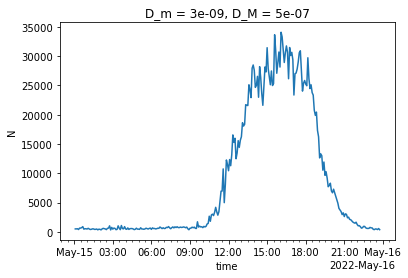

In [474]:
dc1['dndlDp'].bnn.get_exact_N(3e-9,500e-9).bnn.set_time().plot()
bfu.format_ticks(plt.gca())

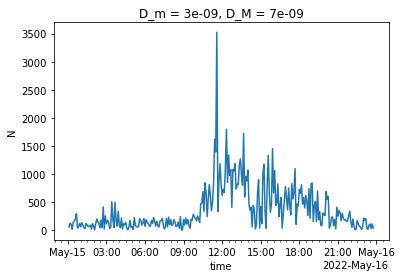

In [475]:
dc1['dndlDp'].bnn.get_exact_N(3e-9,7e-9).bnn.set_time().plot()
bfu.format_ticks(plt.gca())

In [446]:
_l = np.round(np.geomspace(3,500,8)).astype(int)


In [447]:
_tups = [np.array([_l[i_],_l[i_+1]])for i_ in range(len(_l)-1)]

In [448]:
dc1.bnn.set_Dp()['Dp']

<xarray.DataArray 'Dp' (Dp: 53)>
array([1.258925e-09, 1.412538e-09, 1.584893e-09, 1.778279e-09, 1.995262e-09,
       2.238721e-09, 2.511886e-09, 2.818383e-09, 3.162278e-09, 3.548134e-09,
       3.981072e-09, 4.466836e-09, 5.011872e-09, 5.623413e-09, 6.309573e-09,
       7.079458e-09, 7.943282e-09, 8.912509e-09, 1.000000e-08, 1.122018e-08,
       1.258925e-08, 1.412538e-08, 1.584893e-08, 1.778279e-08, 1.995262e-08,
       2.238721e-08, 2.511886e-08, 2.818383e-08, 3.162278e-08, 3.548134e-08,
       3.981072e-08, 4.466836e-08, 5.011872e-08, 5.623413e-08, 6.309573e-08,
       7.079458e-08, 7.943282e-08, 8.912509e-08, 1.000000e-07, 1.122018e-07,
       1.258925e-07, 1.412538e-07, 1.584893e-07, 1.778279e-07, 1.995262e-07,
       2.238721e-07, 2.511886e-07, 2.818383e-07, 3.162278e-07, 3.548134e-07,
       3.981072e-07, 4.466836e-07, 5.011872e-07])
Coordinates:
    lDp      (Dp) float64 -8.9 -8.85 -8.8 -8.75 -8.7 ... -6.45 -6.4 -6.35 -6.3
  * Dp       (Dp) float64 1.259e-09 1.413e-09 1.585e-09 ... 4.467e-07 5.012e-07

In [449]:
t_

array([241., 500.])

In [450]:
cm = plt.get_cmap('plasma')

In [451]:
from matplotlib.lines import Line2D
print(Line2D.markers.keys())

dict_keys(['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''])


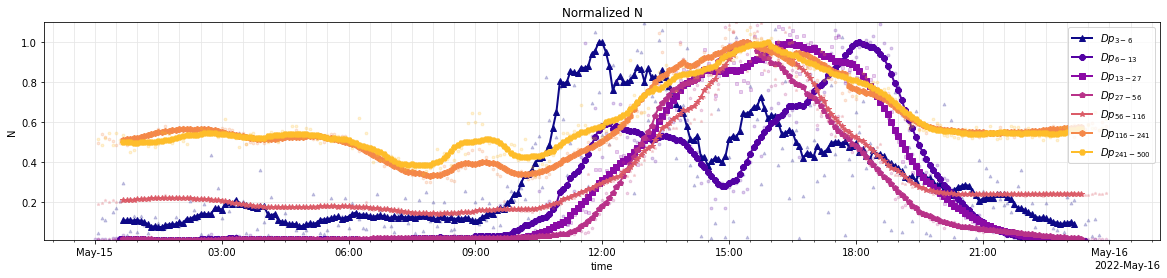

In [522]:
m_=[ '^', '8', 's', 'p', '*', 'h', 'H']
for i,t_ in enumerate(_tups):
    _d = dc1['dndlDp'].bnn.get_exact_N(*(t_*1e-9))
    _d1 = _d.rolling({'secs':15},center=True).mean()
    (_d/_d1.max()).bnn.set_time().plot(
        x='time',label='',c=cm(i/len(_tups)),lw=0,marker = m_[i],alpha=.2,ms=3)
    
        
    (_d1/_d1.max()).bnn.set_time().plot(
        x='time',label=f'$Dp_{{{t_[0]}-{t_[1]}}}$',c=cm(i/len(_tups)),lw=2,marker = m_[i])
    
ax = plt.gca()
ax.legend()
bfu.format_ticks(ax)
f= plt.gcf()
f.set_figwidth(20)
# ax.set_yscale('log')

ax.set_ylim(1e-2,1.1)
ax.grid(which='both',c='.9')
ax.set_title('Normalized N');

In [523]:
d1 = 7e-9 
d2 = 20e-9 

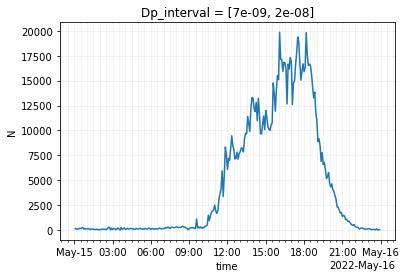

In [524]:
dc1['dndlDp'].bnn.get_exact_N(d1,d2).bnn.set_time().plot()
bfu.format_ticks(plt.gca())
ax = plt.gca()
ax.grid(which='both',alpha=.2)

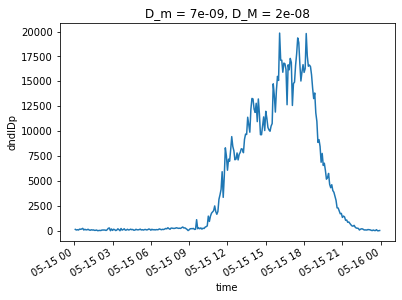

In [347]:
new_inte['dndlDp'].bnn.set_time().plot()

In [21]:
# dc in m3 
dcM = dc1 * 1e6

In [22]:
T = 270 
P = 100000

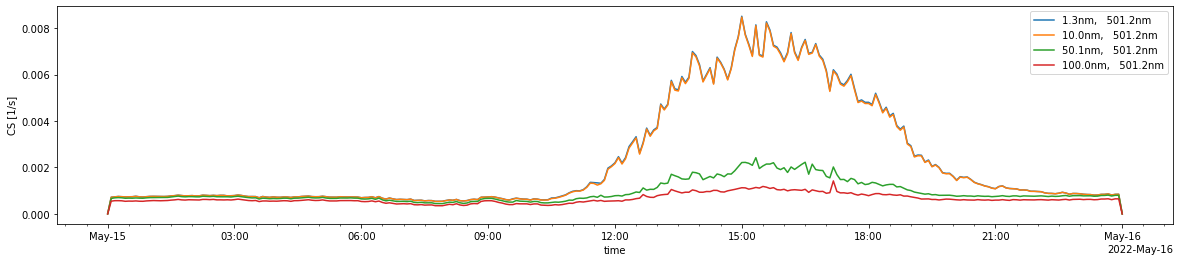

In [23]:
def _plt1(d1_,d2_):
    
    dN, d1,d2 = dcM.bnn.get_dN(d1_,d2_)
    dN_m3 = dN 
    

    cs_ = cs.calc_CS(dN_m3=dN_m3,P=P,T=T)
    cs_.bnn.set_time().plot(label=f'{d1*1e9:.1f}nm,   {d2*1e9:.1f}nm')
    ax = plt.gca()
    ax.legend()
    bfu.format_ticks(ax)
    f = plt.gcf()
    f.set_figwidth(20)

_plt1(1e-9,1000e-9)
_plt1(10e-9,1000e-9)
_plt1(50e-9,1000e-9)
_plt1(100e-9,1000e-9)


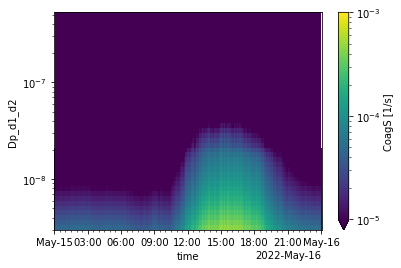

In [94]:
def _plt_coag_snk():
    dN_m3,d1,d2 = dcM.bnn.set_Dp()['dndlDp'].bnn.get_dN(0,1)
    dens1 = dens2 = 1200 
    alpha = 1 
    d1 = 3e-9
    d2 = 10000e-9

    _r = cs.calc_coag_snk_xr(dN_tot_m3 = dN_m3 , d1 = d1, d2 = d2 , P = P, T = T , alpha = alpha, dens1 = dens1, dens2 = dens2)

    __r = _r['CoagS'].bnn.set_time()
    __r.bnn.set_time().plot(norm=mpl.colors.LogNorm(vmin=1e-5,vmax = 1e-3),yscale='log', robust = True)
    bfu.format_ticks(plt.gca())
_plt_coag_snk()

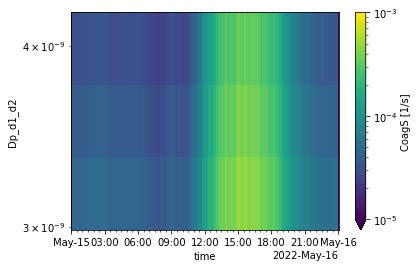

In [111]:
    dN_m3,d1,d2 = dcM.bnn.set_Dp()['dndlDp'].bnn.get_dN(0,1)
    dens1 = dens2 = 1200 
    alpha = 1 
    d1 = 3e-9
    d2 = 4e-9

    _r = cs.calc_coag_snk_xr(dN_tot_m3 = dN_m3 , d1 = d1, d2 = d2 , P = P, T = T , alpha = alpha, dens1 = dens1, dens2 = dens2)

    __r = _r['CoagS'].bnn.set_time()
    __r.bnn.set_time().plot(norm=mpl.colors.LogNorm(vmin=1e-5,vmax = 1e-3),yscale='log', robust = True)
    bfu.format_ticks(plt.gca())

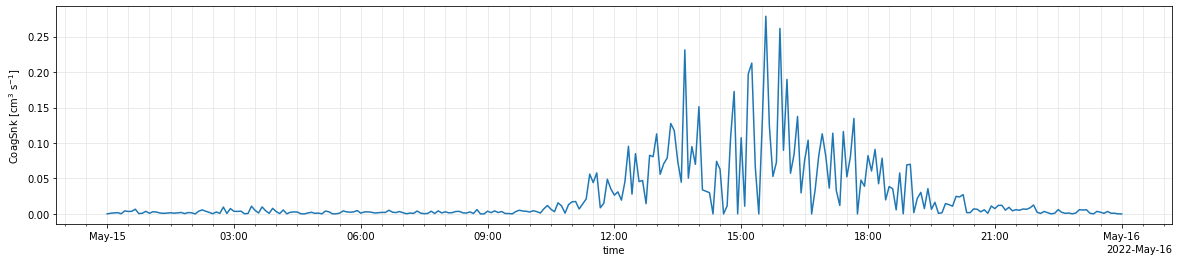

In [464]:
r1 = _r['CoagSnk']*1e-6
r1.bnn.u(r'cm$^3$ s$^{-1}$')
r1.bnn.set_time().plot()
ax = plt.gca()
ax.grid(which='both',color='.9')
plt.gcf().set_figwidth(20)
bfu.format_ticks(ax)

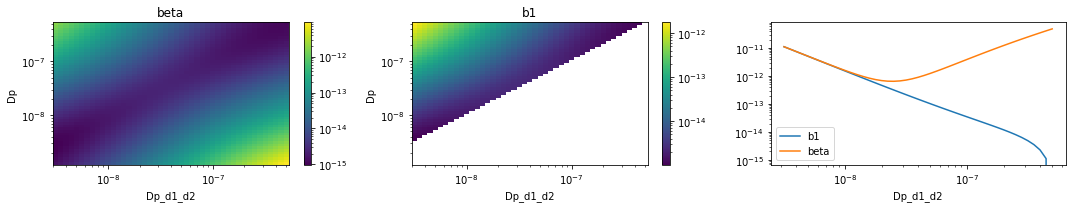

In [88]:
def method_name():
    f, axs = plt.subplot_mosaic('abc', figsize=(3 * 5, 3))

    dN_m3, d1, d2 = dcM.bnn.set_Dp()['dndlDp'].bnn.get_dN(0, 1)
    dens1 = dens2 = 1200
    alpha = 1
    d1 = 3e-9
    d2 = 1000e-9

    _Dp12 = dN_m3['Dp'].loc[{'Dp': slice(d1, d2)}]
    Dp12 = xr.DataArray(_Dp12.values, dims='Dp_d1_d2', coords={'Dp_d1_d2': _Dp12.values})

    Dp_, Dp12_ = xr.broadcast(dN_m3['Dp'], Dp12)


    def _calc_beta(Dp12_, Dp_, alpha, axs, dens1, dens2):
        beta = cs.calc_coag_coef_fuchs(
            d1=Dp12_, dens1=dens1, d2=Dp_, dens2=dens2, T=T, P=P, alpha=alpha)
        b1 = beta.where(beta['Dp'] > beta['Dp_d1_d2'])
        beta.plot(yscale='log', xscale='log', norm=mpl.colors.LogNorm(), ax=axs['a'])
        b1.plot(yscale='log', xscale='log', norm=mpl.colors.LogNorm(), ax=axs['b'])
        ax = axs['c']
        b1.sum('Dp').plot(label='b1', ax=ax)
        beta.sum('Dp').plot(label='beta', ax=ax)
        ax = plt.gca()
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend()
        axs['a'].set_title('beta')
        axs['b'].set_title('b1')
        f.tight_layout()
        
    _calc_beta(Dp12_, Dp_, alpha, axs, dens1, dens2)

method_name()   

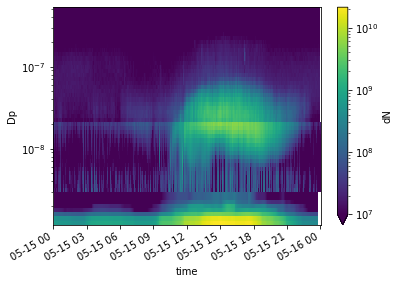

In [89]:
(dN_m3+.00001).bnn.set_time().plot(norm=mpl.colors.LogNorm(vmin=1e7),yscale='log')